In [1]:
import os, sys
sys.path.append("../../")
from utils import utils
import numpy as np
import collections
import json
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 14, colors = 'banskt', dpi = 90)

tissue_file = "../../plots/tissue_table.txt"
json_file   = "../../gtex_v8_metadata.json"
tshorts, tfulls, tstrings = utils.read_tissues_str(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        tissue_nsamples[tshort] = gtex_meta[tfull]["rnaSeqSampleCount"]
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

In [2]:
def read_fst_file(infile):
    fst_dict = dict()
    for i in range(1,23):
        fst_dict[i] = dict()
        with open(infile.format(i)) as instream:
            next(instream)
            for line in instream:
                arr = line.strip().split("\t")
                if line.strip() == "":
                    continue
                fst_dict[int(arr[0])][int(arr[1])] = float(arr[2])
    return fst_dict

def read_fst_file_1kg(infile):
    fst_dict = dict()
    for i in range(1,23):
        fst_dict[i] = dict()
    with open(infile) as instream:
        next(instream)
        for line in instream:
            arr = line.strip().split("\t")
            if line.strip() == "":
                continue
            fst_dict[int(arr[0])][int(arr[1])] = float(arr[2])
    return fst_dict

fst_file_1kg = "/cbscratch/franco/from_saikat/EUR-AFR.weir.fst"
fst_1kg = read_fst_file_1kg(fst_file_1kg)

In [3]:
fst_file_gtex_2pop = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_v8_SHAPEIT2_EUR-AFR-chr{:d}.weir.fst"
fst_file_gtex_3pop = "/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/GTEx_v8_SHAPEIT2_EUR-AFR-OTH-chr{:d}.weir.fst"
fst_gtex_2pop = read_fst_file(fst_file_gtex_2pop)
fst_gtex_3pop = read_fst_file(fst_file_gtex_3pop)


In [4]:
gtex_snp_map = dict()
gtex_varid_fst_2pop = dict()
gtex_varid_fst_3pop = dict()
snps_list = list()
for i in np.arange(1,23):
    gtex_snp_map[i] = dict()
with open("/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/0.01/gtex_v8_snpinfo_SHAPEIT2.txt") as instream:
    for line in instream:
        arr = line.strip().split(" ")
        chrom = int(arr[0])
        pos = int(arr[2])
        gtex_snp_map[chrom][pos] = arr[1]
        gtex_varid_fst_2pop[arr[1]] = fst_gtex_2pop[chrom][pos]
        gtex_varid_fst_3pop[arr[1]] = fst_gtex_3pop[chrom][pos]
        snps_list.append(arr[1])
        

In [ ]:
# # Tissue specific fsts
# fst_gtex_tissues_3pop = dict()
# for tissue in tshorts:
#     fst_gtex_dir = f"/cbscratch/franco/datasets/gtex_v8/genotypes/vcfs_SHAPEIT2/fst/{tissue}"
#     filename = "GTEx_v8_SHAPEIT2_EUR-AFR-OTH-chr{:d}.weir.fst"
#     fst_file_gtex_tissue = os.path.join(fst_gtex_dir, filename)
#     fst_gtex_tissues_3pop[tissue] = read_fst_file(fst_file_gtex_tissue)

In [5]:
kg1 = list()
pop2 = list()
pop3 = list()
for i in range(1,5):
    for pos in fst_gtex_2pop[i]:
        if fst_1kg[i].get(pos,False):
            pop2.append(fst_gtex_2pop[i][pos])
            kg1.append(fst_1kg[i][pos])
            pop3.append(fst_gtex_3pop[i][pos])

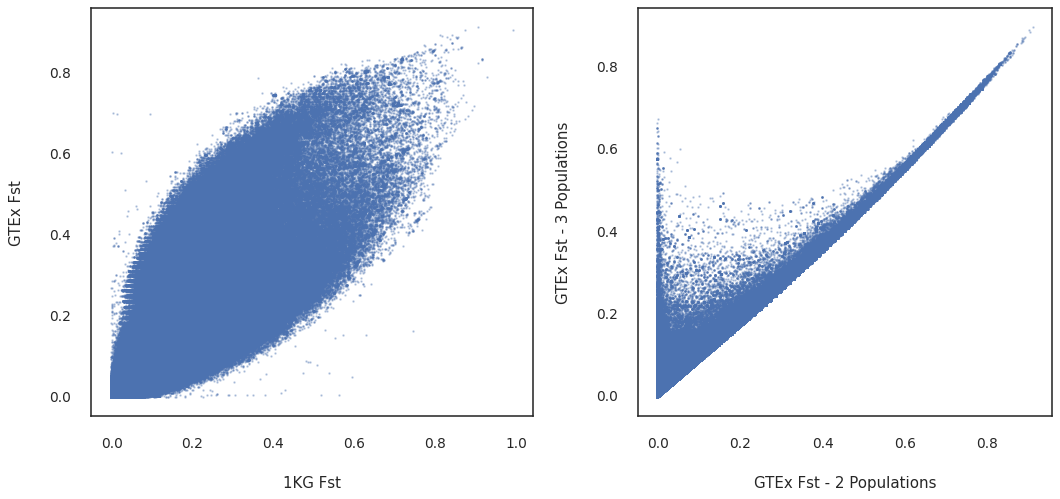

In [9]:
import seaborn as sns
sns.set(style="white")

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

ax1.scatter(kg1,pop2, s=1, alpha=0.3)
ax2.scatter(pop2,pop3, s=1, alpha=0.3)

ax1.set_xlabel("1KG Fst")
ax1.set_ylabel("GTEx Fst")

ax2.set_xlabel("GTEx Fst - 2 Populations")
ax2.set_ylabel("GTEx Fst - 3 Populations")

ax1.set_aspect("equal")
ax2.set_aspect("equal")
plt.show()

In [6]:
SNPRES_FIELDS = ['rsid', 'chrom', 'pos', 'logp', 'maf']
class SNPRes(collections.namedtuple('_SNPRes', SNPRES_FIELDS)):
    __slots__ = ()

def tejaas(filepath):
    res = list()
    with open(filepath, 'r') as mfile:
        next(mfile)
        for line in mfile:
            arr   = line.strip().split("\t")
            rsid  = arr[0]
            #chrom = rsid.split("_")[0][3:]
            chrom = int(arr[1])
            pos   = int(arr[2])
            p     = float(arr[7])
            logp  = np.log10(p) if p!=0 else np.log10(10e-30)
            maf   = float(arr[3])
            res.append(SNPRes(rsid=rsid, chrom=chrom, pos=pos, logp=-logp, maf=maf))
    return res    
    
basename = "protein_coding_lncRNA_{:s}_knn30_cut5e-8"
gammas = ["gamma01", "gamma0006"]

In [7]:
basepath = "/cbscratch/franco/trans-eqtl"

trans_dict = dict()

for tissue in tshorts:
    if tissue in altsb_tissues:
        config = basename.format(gammas[1])
    else:
        config = basename.format(gammas[0])
    tejaas_file = os.path.join(basepath, config, tissue, "trans_eqtls_ldpruned.txt")
    
    if not os.path.exists(tejaas_file):
        print("{:s} has no trans-eqtl results".format(tissue))
        continue
    print("Loading ", tissue, end="")
    transeqtls = tejaas(tejaas_file)
    if len(transeqtls) > 0:
        trans_dict[tissue] = transeqtls
        print(" has {:d} trans-eqtls".format(len(transeqtls)))
    else:
        trans_dict[tissue] = []
        print(" has 0 trans-eqtls")

Loading  as has 586 trans-eqtls
Loading  av has 463 trans-eqtls
Loading  ag has 184 trans-eqtls
Loading  aa has 1298 trans-eqtls
Loading  ac has 1539 trans-eqtls
Loading  at has 391 trans-eqtls
Loading  bam has 1182 trans-eqtls
Loading  ban has 954 trans-eqtls
Loading  bca has 19 trans-eqtls
Loading  bceh has 128 trans-eqtls
Loading  bce has 40 trans-eqtls
Loading  bco has 64 trans-eqtls
Loading  bfr has 32 trans-eqtls
Loading  bhi has 51 trans-eqtls
Loading  bhy has 83 trans-eqtls
Loading  bnu has 379 trans-eqtls
Loading  bpu has 10 trans-eqtls
Loading  bsp has 61 trans-eqtls
Loading  bsu has 28 trans-eqtls
Loading  br has 505 trans-eqtls
Loading  ebv has 297 trans-eqtls
Loading  fib has 209 trans-eqtls
Loading  cols has 75 trans-eqtls
Loading  colt has 1174 trans-eqtls
Loading  esog has 17 trans-eqtls
Loading  esom has 9 trans-eqtls
Loading  esomu has 20 trans-eqtls
Loading  haa has 64 trans-eqtls
Loading  hlv has 247 trans-eqtls
Loading  kc has 14 trans-eqtls
Loading  liv has 37 tra

In [8]:
fst_teqtl_gtex= dict()
all_fst_teqtl_2pop = list()
all_fst_teqtl_3pop = list()
all_fst_teqtl_1kg = list()
# all_fst_teqtl_tissuespec_3pop = list()

counted = list()
for tissue in tshorts:
    fst_teqtl_gtex[tissue] = list()
    for snp in trans_dict[tissue]:
        if snp.rsid not in counted:
            fst_teqtl_gtex[tissue].append(fst_gtex_2pop[snp.chrom][snp.pos])
            all_fst_teqtl_2pop.append(fst_gtex_2pop[snp.chrom][snp.pos])
            all_fst_teqtl_3pop.append(fst_gtex_3pop[snp.chrom][snp.pos])
            if snp.pos in fst_1kg[snp.chrom]:
                all_fst_teqtl_1kg.append(fst_1kg[snp.chrom][snp.pos])
            counted.append(snp.rsid)
#         all_fst_teqtl_tissuespec_3pop.append(fst_gtex_tissues_3pop[tissue][snp.chrom][snp.pos])
        
all_fst_teqtl_2pop = np.array(all_fst_teqtl_2pop)
all_fst_teqtl_3pop = np.array(all_fst_teqtl_3pop)
all_fst_teqtl_1kg = np.array(all_fst_teqtl_1kg)
# all_fst_teqtl_tissuespec_3pop = np.array(all_fst_teqtl_tissuespec_3pop)

In [ ]:
# compare MAF and Fst values for trans-eqtls

In [22]:
counts, bins = np.histogram(all_fst_teqtl_2pop[~np.isnan(all_fst_teqtl_2pop)], bins=20, range=(0,1))
print(counts, bins)

[1364  332  369  603  886 1223 1570 1685 1736 1618 1382 1307 1181  987
  886  640  419   82   12    0] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]


/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/users/fsimone/opt/miniconda/3/envs/env3.6/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


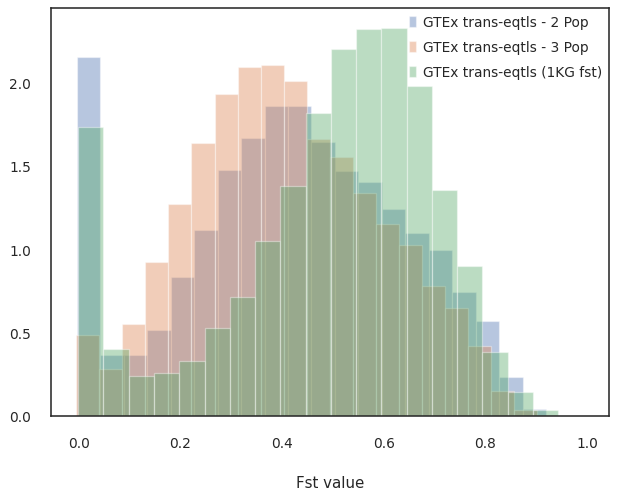

In [24]:
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)
ax1.hist(all_fst_teqtl_2pop, bins=20, density=True, alpha=0.4, label="GTEx trans-eqtls - 2 Pop")
ax1.hist(all_fst_teqtl_3pop, bins=20, density=True, alpha=0.4, label="GTEx trans-eqtls - 3 Pop")
ax1.hist(all_fst_teqtl_1kg, bins=20, density=True, alpha=0.4, label="GTEx trans-eqtls (1KG fst)")
# ax1.hist(all_fst_teqtl_tissuespec_3pop, bins=20, density=True, alpha=0.4, label="GTEx trans-eqtls (tissue-matched)")
ax1.legend(loc='upper right')
ax1.set_xlabel("Fst value")

plt.show()

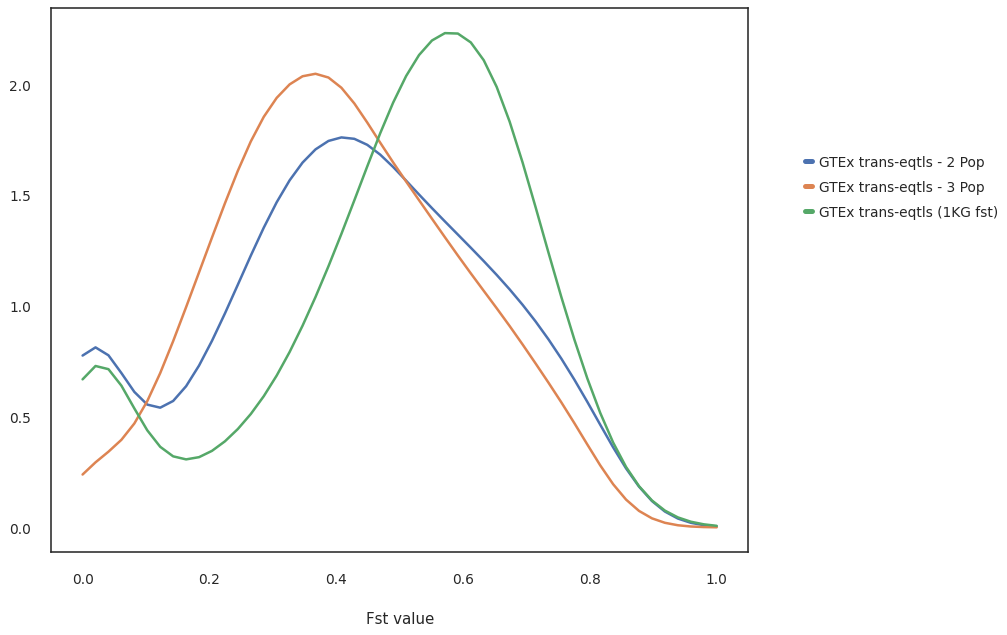

In [25]:
from scipy.stats import gaussian_kde

fig = plt.figure(figsize=(10,8))
ax1 = fig.add_subplot(111)

xs = np.linspace(0,1,50)

density = gaussian_kde(all_fst_teqtl_2pop)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs, density(xs), label="GTEx trans-eqtls - 2 Pop", linewidth=2.0)

density = gaussian_kde(all_fst_teqtl_3pop)
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs, density(xs), label="GTEx trans-eqtls - 3 Pop", linewidth=2.0)

density = gaussian_kde(all_fst_teqtl_1kg[~np.isnan(all_fst_teqtl_1kg)])
density.covariance_factor = lambda : .25
density._compute_covariance()
ax1.plot(xs, density(xs), label="GTEx trans-eqtls (1KG fst)", linewidth=2.0)

# density = gaussian_kde(all_fst_teqtl_tissuespec_3pop[~np.isnan(all_fst_teqtl_tissuespec_3pop)])
# density.covariance_factor = lambda : .25
# density._compute_covariance()
# ax1.plot(xs, density(xs), label="GTEx trans-eqtls (tissue-matched)", linewidth=2.0)

leg = ax1.legend(loc='lower center', bbox_to_anchor=(1.22, 0.6))
for line in leg.get_lines():
    line.set_linewidth(4.0)
ax1.set_xlabel("Fst value")

plt.show()

In [47]:
# Generate the binned list of SNP ids for all GTEx

bins = np.arange(19)* 0.05
gtex_fst_bins = collections.defaultdict(list)
bin_width = 0.05
print(bins)
for varid in gtex_varid_fst_3pop:
    good = False
    fst_val = gtex_varid_fst_3pop[varid]
    if fst_val < 0:
        gtex_fst_bins[np.around(bins[0], 2)].append(varid)
    else:
        for b in bins:
            if fst_val >= np.around(b, 2) and fst_val < np.around(b, 2)+bin_width:
                gtex_fst_bins[np.around(b, 2)].append(varid)
                good = True
                break
        if not good:
            print("this fst", fst_val)
            for b in bins:
                print(f"{fst_val} == {b} : {fst_val == b} | {fst_val} >= {b} : {fst_val >= b}")
            raise

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9 ]


In [48]:
# save them in a json file
with open("gtex_fst_bins_3pop.json", 'w') as outf:
    json.dump(gtex_fst_bins, outf)

In [52]:
# save list of gtex ids and fst values

with open("gtex_3pop_fsts.txt", 'w') as outf:
    for varid in gtex_varid_fst_3pop:
        outf.write(f"{varid} {gtex_varid_fst_3pop[varid]}\n")

In [53]:
# Load Fst dict for gtex
gtex_fst_dict_test = dict()
with open("../fst_analysis/gtex_3pop_fsts.txt") as instream:
    for line in instream:
        arr = line.strip().split()
        fst = float(arr[1])
        gtex_fst_dict_test[arr[0]] = fst if fst >= 0.0 else 0.0

In [49]:
acum = 0
for i in gtex_fst_bins:
    print(len(gtex_fst_bins[i]))
    acum += len(gtex_fst_bins[i])
print(acum)

4366516
1042282
483683
411970
263482
83033
552250
122821
406420
186967
53004
12062
34634
5915
20867
47
2117
584
1
8048655


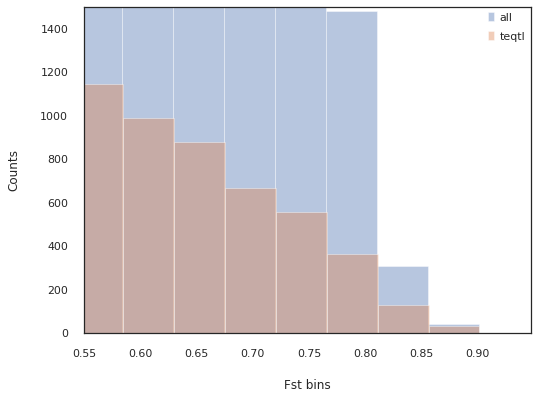

In [86]:
#compare Fst distribution of all gtex to trans-eqtl only fsts
all_gtex_fst_3pop = [gtex_varid_fst_3pop[x] for x in gtex_varid_fst_3pop]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.hist(all_gtex_fst_3pop, bins=20, alpha=0.4, label="all")
ax.hist(all_fst_teqtl_3pop, bins=20, alpha=0.4, label="teqtl")
ax.set_xlim(0.55,)
ax.set_ylim(0,1500)
ax.set_xlabel("Fst bins")
ax.set_ylabel("Counts")
ax.legend()
plt.show()

In [87]:
# save the Fst bins for all trans-eqtls
with open("gtex_teqtl_bininfo.txt", 'w') as outf:
    for i in range(len(counts)):
        outf.write(f"{np.around(bins[i],2)}\t{counts[i]}\n")

In [95]:
def sample_random_fst(snps_list, gtex_fst_bins, fst_distrib):
    hist_range=(0,1)
    bin_w=0.05
    nbins = int(max(hist_range)/bin_w)

    target_distrib_counts, bins = np.histogram(np.array(fst_distrib)[~np.isnan(fst_distrib)], bins=nbins, range=hist_range)
    print(target_distrib_counts, bins)

    res_list = list()
    res_dict = dict()
    for chrm in np.arange(1, 23):
        res_dict[chrm] = list()

    for i,c in enumerate(target_distrib_counts):
        curr_bin = np.around(bins[i],2)
        if c <= 0:
            continue
        if curr_bin not in gtex_fst_bins:
            print(f"Problem! {curr_bin} not in gtex_fst_bins")
            raise
        if c > len(gtex_fst_bins[curr_bin]):
            print("Error, c cannot be larger than available snps in that bin")
            raise
        print(f"sample {c} from {len(gtex_fst_bins[curr_bin])}")
        chooseidx = np.sort(np.random.choice(len(gtex_fst_bins[curr_bin]), c, replace = False))
        for idx in chooseidx:
            var_id = gtex_fst_bins[curr_bin][idx]
            info = var_id.split('_')
            chrm = int(info[0][3:])
            bppos = int(info[1])
            res_dict[chrm].append(bppos)
            res_list.append(var_id)
    return res_dict, res_list

[ 406  312  653 1034 1370 1783 1907 1985 1903 1584 1392 1254 1004  888
  635  464  192   34    1    0] [0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
sample 406 from 3677848
sample 312 from 1042282
sample 653 from 552250
sample 1034 from 411970
sample 1370 from 483683
sample 1783 from 406420
sample 1907 from 263480
sample 1985 from 186967
sample 1903 from 122821
sample 1584 from 83033
sample 1392 from 53004
sample 1254 from 34634
sample 1004 from 20867
sample 888 from 12062
sample 635 from 5915
sample 464 from 2117
sample 192 from 584
sample 34 from 47
sample 1 from 1


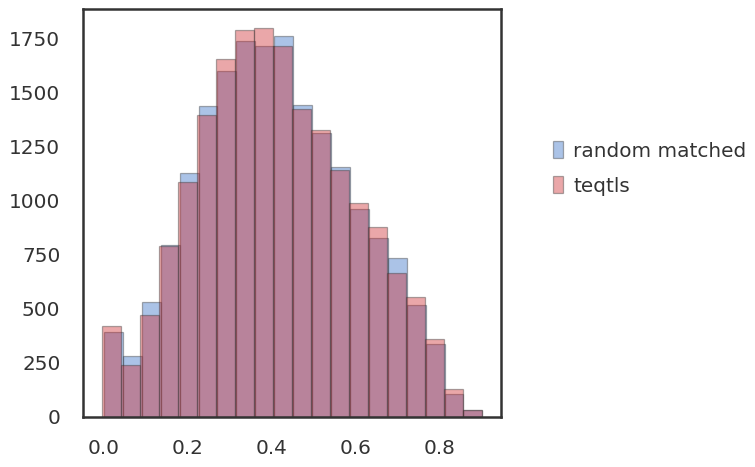

In [103]:
res_dict, res_list = sample_random_fst(snps_list, gtex_fst_bins, all_fst_teqtl_3pop)
random_matched_gtex_fst = [gtex_varid_fst_3pop[x] for x in res_list]
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
ax.hist(random_matched_gtex_fst, bins=20, alpha=0.4, label="random matched")
ax.hist(all_fst_teqtl_3pop, bins=20, alpha=0.4, label="teqtls")
ax.legend(bbox_to_anchor=(1.1, 0.7))
plt.show()